In [11]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
with open('drugs.txt', 'r') as f:
    drug_list = f.read().splitlines()

In [13]:
chars = sorted(list(set("".join(drug_list)))) + ['<e>', '<s>']

In [14]:
counts = {c:0 for c in chars}

for drug in drug_list:
    for c in drug:
        counts[c] += 1

In [15]:
counts

{' ': 899,
 '%': 3,
 "'": 2,
 ',': 7,
 '-': 97,
 '.': 9,
 '/': 11,
 '0': 18,
 '1': 20,
 '2': 17,
 '3': 12,
 '4': 4,
 '5': 8,
 '7': 3,
 '8': 4,
 '9': 4,
 'a': 3123,
 'b': 455,
 'c': 1409,
 'd': 1218,
 'e': 3388,
 'f': 513,
 'g': 343,
 'h': 706,
 'i': 3036,
 'j': 19,
 'k': 91,
 'l': 2021,
 'm': 1205,
 'n': 2419,
 'o': 2629,
 'p': 1063,
 'q': 55,
 'r': 2293,
 's': 1205,
 't': 2074,
 'u': 751,
 'v': 497,
 'w': 23,
 'x': 511,
 'y': 535,
 'z': 362,
 '<e>': 0,
 '<s>': 0}

In [16]:
vocab_size = len(chars)
tokenizer = dict(zip(chars, range(vocab_size)))
detokenizer = dict(zip(range(vocab_size), chars))

In [17]:
# generating the dataset
context_length = 6
X = []
Y = []

for drug in drug_list:
    context = ['<s>'] * context_length
    for i, c in enumerate(drug):
        context = context[1:] + [c]
        X.append([tokenizer[c] for c in context])
        if i < len(drug) - 1:
            Y.append(tokenizer[drug[i + 1]])
        else:
            Y.append(tokenizer["<e>"])

X = torch.tensor(X)
Y = torch.tensor(Y)

In [18]:
tst_idx = int(X.shape[0])
val_idx = int(tst_idx * 0.9)
tr_idx =  int(tst_idx * 0.8)

X_tr = X[0:tr_idx]
Y_tr = Y[0:tr_idx]

X_val = X[tr_idx:tst_idx]
Y_val = Y[tr_idx:tst_idx]

X_tst = X[val_idx:]
Y_tst = Y[val_idx:]

In [19]:
EMBEDDING_DIM = 8
HIDDEN_LAYER_1_SIZE = 70
HIDDEN_LAYER_2_SIZE = 30
LR = 1e-2

NUM_EPOCHS = 200000
BATCH_SIZE = 64


E = torch.randn(vocab_size, EMBEDDING_DIM)
W_1 = torch.randn(EMBEDDING_DIM * context_length, HIDDEN_LAYER_1_SIZE) * (5/3) / (EMBEDDING_DIM * context_length) ** 0.5
B_1 = torch.randn(HIDDEN_LAYER_1_SIZE)  # Fixed: should match hidden layer size
BN_y = torch.ones(1)
BN_B = torch.zeros(1)

W_2 = torch.randn(HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE) * (5/3) / (HIDDEN_LAYER_1_SIZE) ** 0.5
B_2 = torch.randn(HIDDEN_LAYER_2_SIZE)  # Fixed: should match hidden layer size
BN_y_2 = torch.ones(1)
BN_B_2 = torch.zeros(1)

W_3 = torch.randn(HIDDEN_LAYER_2_SIZE, vocab_size) * 0.01

parameters = [E, W_1, W_2, W_3, B_1, B_2, BN_y, BN_y_2, BN_B, BN_B_2]

# batch, 

for p in parameters:
    p.requires_grad = True

In [20]:
losses = []

for batch_num in range(NUM_EPOCHS):
    for p in parameters:
        p.grad = None

    batch_ix = torch.randint(0, X_tr.shape[0], (64,))


    xs = X_tr[batch_ix]
    y = Y_tr[batch_ix]

    emb = E[xs].view(-1, EMBEDDING_DIM * context_length)

    x = (emb @ W_1) + B_1
    x = (BN_y * (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)) + BN_B

    # plt.hist(x.detach().flatten().numpy())
    # plt.show()

    x = torch.tanh(x)

    # plt.hist(x.detach().flatten().numpy())
    # plt.show()

    x = (x @ W_2) + B_2
    x = (BN_y_2 * (x - x.mean(0, keepdim=True)) / x.std(0, keepdim=True)) + BN_B_2

    # plt.hist(x.detach().flatten().numpy())
    # plt.show()

    x = torch.tanh(x)

    # plt.hist(x.detach().flatten().numpy())
    # plt.show()
    logits = x @ W_3

    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()

    for p in parameters:
        p.data -= p.grad * LR

    losses.append(loss.item())
    break

plt.plot(losses)


TypeError: 'list' object is not callable

In [ ]:
with torch.no_grad():
    xs = X_val
    y = Y_val

    emb = E[xs].view(-1, EMBEDDING_DIM * context_length)

    x = (emb @ W_1) + B_1

    bn_mean = x.mean(0, keepdim=True)
    bn_std = x.std(0, keepdim=True)
    x = (BN_y * (x - bn_mean) / bn_std) + BN_B

    x = torch.tanh(x)

    x = (x @ W_2) + B_2

    bn_mean_2 = x.mean(0, keepdim=True)
    bn_std_2 = x.std(0, keepdim=True)
    x = (BN_y_2 * (x - bn_mean_2) / bn_std_2) + BN_B_2

    x = torch.tanh(x)
    logits = x @ W_3

    loss = torch.nn.functional.cross_entropy(logits, y)

    print(loss.item())

2.39752459526062


In [ ]:
with torch.no_grad():
    xs = X_tr
    y = Y_tr

    emb = E[xs].view(-1, EMBEDDING_DIM * context_length)

    x = (emb @ W_1) + B_1

    bn_mean = x.mean(0, keepdim=True)
    bn_std = x.std(0, keepdim=True)
    x = (BN_y * (x - bn_mean) / bn_std) + BN_B

    x = torch.tanh(x)

    x = (x @ W_2) + B_2

    bn_mean_2 = x.mean(0, keepdim=True)
    bn_std_2 = x.std(0, keepdim=True)
    x = (BN_y_2 * (x - bn_mean_2) / bn_std_2) + BN_B_2

    x = torch.tanh(x)
    logits = x @ W_3

    loss = torch.nn.functional.cross_entropy(logits, y)

    print(loss.item())

1.7088016271591187


In [ ]:
# INFER
samples = 10
context = [tokenizer['<s>']] * context_length

print(context)

with torch.no_grad():
    while context[-1] != tokenizer['<e>']:
        emb = E[torch.tensor(context[-6:]).unsqueeze(0)].view(-1, EMBEDDING_DIM * context_length)

        x = (emb @ W_1) + B_1

        x = (BN_y * (x - bn_mean) / bn_std) + BN_B

        x = torch.tanh(x)

        x = (x @ W_2) + B_2
        x = (BN_y_2 * (x - bn_mean_2) / bn_std_2) + BN_B_2

        x = torch.tanh(x)
        logits = x @ W_3

        prob = torch.exp(logits) / torch.exp(logits).sum()

        # plt.imshow(prob.detach().numpy())
        # plt.xticks(range(len(chars)), chars)
        # plt.show()

        sampled_token = torch.multinomial(prob, 1).item()

        context = context + [sampled_token]

    print("".join(map(lambda x: detokenizer[x], context[context_length:-1])))

[43, 43, 43, 43, 43, 43]
aproponanine


In [ ]:
torch.save({
    'E': E,
    'W_1': W_1,
    'B_1': B_1,
    'BN_y': BN_y,
    'BN_B': BN_B,
    'W_2': W_2,
    'B_2': B_2,
    'BN_y_2': BN_y_2,
    'BN_B_2': BN_B_2,
    'W_3': W_3,
    'chars': chars,
    'tokenizer': tokenizer,
    'detokenizer': detokenizer,
    'context_length': context_length,
    'embedding_dim': EMBEDDING_DIM,
    'bn_mean': bn_mean,
    'bn_std': bn_std,
    'bn_mean_2': bn_mean_2,
    'bn_std_2': bn_std_2
}, 'drugs_model.pt')

### in classes

In [44]:
class Linear():
    def __init__(self, in_features, out_features, bias=True):
        W = torch.randn(in_features, out_features) * (5/3) / (in_features ** 0.5)
        B = torch.zeros(out_features)

        self.W = W

        if bias:
            self.B = B
            self.parameters = [W, B]
        else:
            self.parameters = [W]

        for p in self.parameters:
            p.requires_grad = True

    def __call__(self, x):

        for p in self.parameters:
            p.grad = None

        self.out = (x @ self.W) + self.B

        return self.out
    
    def step(self):
        for p in self.parameters:
            p.data -= p.grad * LR
    

class BatchNorm():
    def __init__(self, num_features=None, eps=1e-05, momentum=0.1, track_running_stats=True):
        # TODO: check what is num_features for
        
        self.BN_y = torch.ones(1)
        self.BN_b = torch.zeros(1)

        self.BN_mean = None
        self.BN_var = None

        self.momentum = momentum
        self.track_running_stats = track_running_stats
        self.eps = eps

        self.parameters = [self.BN_b, self.BN_y]

        for p in self.parameters:
            p.requires_grad = True
    

    def __call__(self, x: torch.Tensor):
        for p in self.parameters:
            p.grad = None

        mean = x.mean(0, keepdim=True)
        var = x.var(0, keepdim=True)

        if self.track_running_stats:
            if self.BN_mean is None:
                self.BN_mean = mean
            if self.BN_var is None:
                self.BN_var = var

            self.BN_mean = ((1 - self.momentum) * self.BN_mean) + (self.momentum * mean)
            self.BN_var = ((1 - self.momentum) * self.BN_var) + (self.momentum * mean)

        self.out = self.BN_y * ((x - mean) / (var + self.eps) ** 0.5) + self.BN_b

        return self.out
    
    def step(self):
        for p in self.parameters:
            p.data -= p.grad * LR
    

class Tanh():
    def __init__(self):
        pass

    def __call__(self, x):
        self.out = torch.tanh(x)

        return self.out
    
    def step(self):
        pass


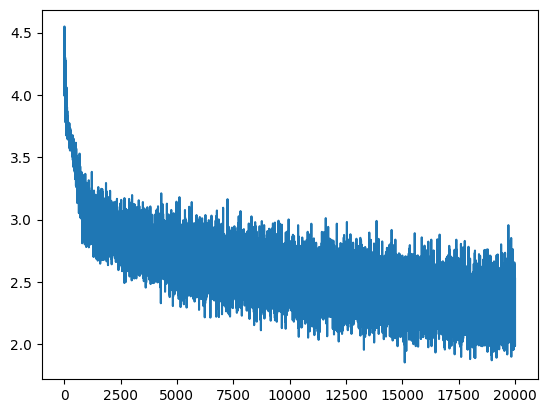

In [45]:
EMBEDDING_DIM = 8
HIDDEN_LAYER_1_SIZE = 70
HIDDEN_LAYER_2_SIZE = 30
LR = 1e-2

NUM_EPOCHS = 20000
BATCH_SIZE = 64


E = torch.randn(vocab_size, EMBEDDING_DIM)

layer_1 = Linear(EMBEDDING_DIM * context_length, HIDDEN_LAYER_1_SIZE, bias=True)
bn_1 = BatchNorm()
layer_2 = Linear(HIDDEN_LAYER_1_SIZE, HIDDEN_LAYER_2_SIZE, bias=True)
bn_2 = BatchNorm()
layer_3 = Linear(HIDDEN_LAYER_2_SIZE, vocab_size)
tanh = Tanh()

model = [layer_1, bn_1, tanh, layer_2, bn_2, tanh, layer_3]

losses = []

for batch_num in range(NUM_EPOCHS):
    batch_ix = torch.randint(0, X_tr.shape[0], (64,))

    xs = X_tr[batch_ix]
    y = Y_tr[batch_ix]

    emb = E[xs].view(-1, EMBEDDING_DIM * context_length)

    x = emb

    for l in model:
        x = l(x)

    loss = torch.nn.functional.cross_entropy(x, y)
    loss.backward()

    for l in model:
        l.step()

    losses.append(loss.item())

plt.plot(losses)



### monitoring

In [ ]:
torch.tensor().num

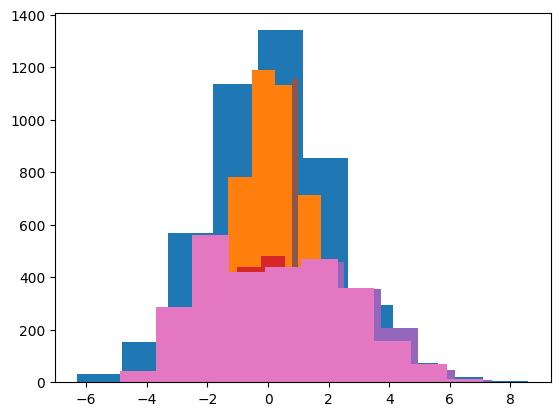

In [ ]:
for l in model:
    plt.hist(l.out.detach().flatten().numpy(), linestyle='--')

In [35]:
detokenizer

{0: ' ',
 1: '%',
 2: "'",
 3: ',',
 4: '-',
 5: '.',
 6: '/',
 7: '0',
 8: '1',
 9: '2',
 10: '3',
 11: '4',
 12: '5',
 13: '7',
 14: '8',
 15: '9',
 16: 'a',
 17: 'b',
 18: 'c',
 19: 'd',
 20: 'e',
 21: 'f',
 22: 'g',
 23: 'h',
 24: 'i',
 25: 'j',
 26: 'k',
 27: 'l',
 28: 'm',
 29: 'n',
 30: 'o',
 31: 'p',
 32: 'q',
 33: 'r',
 34: 's',
 35: 't',
 36: 'u',
 37: 'v',
 38: 'w',
 39: 'x',
 40: 'y',
 41: 'z',
 42: '<e>',
 43: '<s>'}

In [ ]:
print(torch.tensor(context).unsqueeze(0).shape)

torch.Size([1, 6])
